In [1]:
import os
import sys

import pandas as pd

pd.set_option("mode.copy_on_write", True)

script_dir = os.path.abspath("")
mymodule_dir = os.path.join(script_dir, "..", "scripts")
sys.path.append(mymodule_dir)
import cleaning

jobs = cleaning.prep(
    pd.read_pickle("../data/jobs.pkl"), filtered=False, categories_reduced=False
)
# jobs.head()

In [2]:
jobs = jobs[
    (jobs["Description"] != "Nicht stepstone")
    & (jobs["Description"] != "Stellenanzeige nicht mehr verfügbar")
    & (jobs["Description"] != "")
    & (jobs["Profile"] != "")
]
texts = jobs["Description"] + jobs["Profile"]

In [3]:
import pickle
import re

import nltk
from HanTa import HanoverTagger as ht
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /Users/tim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/tim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
def tokenize_doc(doc):
    stopwords_ger = stopwords.words("german")
    stopwords_ger.extend(["du", "sie"])
    stopwords_en = stopwords.words("english")

    cleaned = re.sub(
        r"[\W](?=\w)",
        " ",
        doc.replace("\u200b", " ")
        .replace("\xad", "")
        .replace("-", " ")
        .replace("/", " ")
        .replace("·", " ")
        .replace("•", " ")
        .replace("…", " "),
    )
    tokenized = word_tokenize(cleaned, language="german")
    alphas = [w.lower() for w in tokenized if w.isalpha()]

    tagger = ht.HanoverTagger("morphmodel_ger.pgz")

    no_stops_de = [w for w in alphas if w not in stopwords_ger]
    no_stops_de_en = [w for w in no_stops_de if w not in stopwords_en]

    lemmatized = [tagger.analyze(token)[0].lower() for token in no_stops_de_en]

    return lemmatized

In [5]:
if os.path.isfile("../data/lemmatized_desc_profile.pkl"):
    with open("../data/lemmatized_desc_profile.pkl", "rb") as file:
        old_lemmas = pickle.load(file)
else:
    old_lemmas = []

lemmas = old_lemmas

docs = [doc for doc in texts]

In [6]:
if len(docs) > len(old_lemmas):
    new_docs = docs[len(old_lemmas) :]
    docs_count = len(new_docs)
    new_lemmas = []
    print(f"Tokenizing {docs_count} documents")
    i = 1
    for doc in new_docs:
        if i % 500 == 0:
            print(f"{i}/{docs_count}")
        new_lemmas.append(tokenize_doc(doc))
        i += 1
    lemmas += new_lemmas

    with open("../data/lemmatized_desc_profile.pkl", "wb") as file:
        pickle.dump(lemmas, file)

Tokenizing 51 documents


In [7]:
from collections import Counter

all_in_one = [w for doc in lemmas for w in doc]
bow = Counter(all_in_one)
bow.most_common(10)

[('sowie', 20281),
 ('data', 16494),
 ('team', 15327),
 ('gut', 14308),
 ('bereich', 13137),
 ('erfahrung', 11495),
 ('kenntnis', 9730),
 ('haben', 9172),
 ('management', 9057),
 ('studium', 8545)]

In [8]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel

dictionary = Dictionary(lemmas)
bow_corpus = [dictionary.doc2bow(doc) for doc in lemmas]
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

# BOW

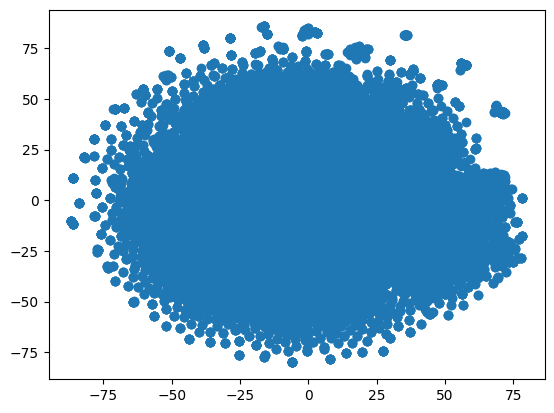

In [9]:
import matplotlib.pyplot as plt
from gensim import matutils
from sklearn.manifold import TSNE

sklearn_vectors = matutils.corpus2csc(bow_corpus).T

model = TSNE(n_components=2, random_state=0, init="random")
transformed = model.fit_transform(sklearn_vectors)
xs = transformed[:, 0]
ys = transformed[:, 1]

plt.scatter(xs, ys)
plt.show()

In [10]:
import pyLDAvis
import pyLDAvis.gensim
from gensim.models.ldamulticore import LdaMulticore

lda_model = LdaMulticore(
    corpus=bow_corpus,
    workers=2,
    id2word=dictionary,
    num_topics=5,
    random_state=100,
    chunksize=50,
    passes=10,
    per_word_topics=True,
)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.192262  0.035304       1        1  27.914563
4      0.181437  0.003408       2        1  25.800217
0     -0.264276 -0.248165       3        1  25.569532
1      0.132744 -0.059395       4        1  20.224563
3     -0.242167  0.268848       5        1   0.491126, topic_info=              Term          Freq         Total Category  logprob  loglift
22            data  16505.000000  16505.000000  Default  30.0000  30.0000
132          haben   9312.000000   9312.000000  Default  29.0000  29.0000
89           sowie  21173.000000  21173.000000  Default  28.0000  28.0000
181     experience   6408.000000   6408.000000  Default  27.0000  27.0000
56        kenntnis   9143.000000   9143.000000  Default  26.0000  26.0000
...            ...           ...           ...      ...      ...      ...
27180    alliancen      7.061458     16.050348   Topic5  -7.2120   4.4951
3913   preclinical      9.665013     47.416234   Topic5  -6.8981   3.7258
10561    photoshop      7.663996     50.804510   Topic5  -7.1301   3.4248
3877      briefing      7.866516     97.388331   Topic5  -7.1040   2.8001
3884          drug      7.518856     61.800035   Topic5  -7.1492   3.2097

[376 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
221        1  0.662730  abgeschlossen
221        2  0.102962  abgeschlossen
221        4  0.234292  abgeschlossen
162        3  0.999667        ability
17907      2  0.996907         abitur
...      ...       ...            ...
507        1  0.153880     übernehmen
507        2  0.755636     übernehmen
507        4  0.090389     übernehmen
1311       1  0.907561    überwachung
1311       4  0.092333    überwachung

[627 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 2, 4])

In [11]:
def calc_topic_for_doc(doc):
    values = []
    tuples = lda_model.get_document_topics(doc)
    for tuple in tuples:
        values.append(tuple[1])
    max_prob = max(values)
    topic = tuples[values.index(max_prob)][0]
    return topic + 1

In [12]:
bow_topic_list = []
for doc in bow_corpus:
    bow_topic_list.append(calc_topic_for_doc(doc))

df_bow = pd.DataFrame(
    {"topics": bow_topic_list, "Job_Kategorie": jobs["Job Kategorie"]}, index=jobs.index
)

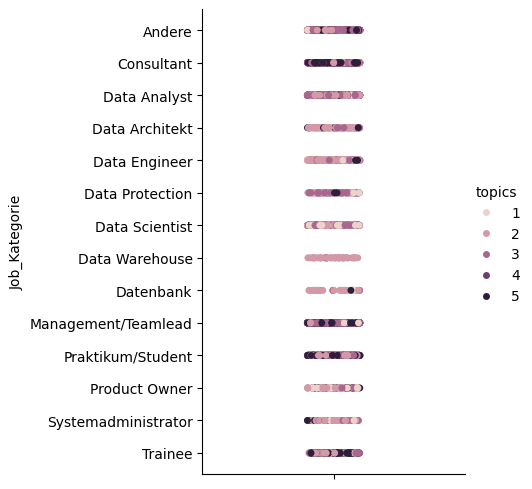

In [13]:
import seaborn as sns

sns.catplot(data=df_bow, hue="topics", y="Job_Kategorie")

# TF-IDF

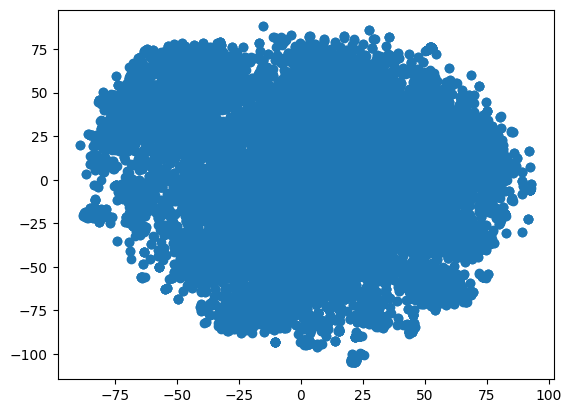

In [14]:
sklearn_vectors = matutils.corpus2csc(tfidf_corpus).T

model = TSNE(n_components=2, random_state=0, init="random")
transformed = model.fit_transform(sklearn_vectors)
xs = transformed[:, 0]
ys = transformed[:, 1]

plt.scatter(xs, ys)
plt.show()

In [15]:
lda_model = LdaMulticore(
    corpus=tfidf_corpus,
    workers=2,
    id2word=dictionary,
    num_topics=3,
    random_state=100,
    chunksize=50,
    passes=10,
    per_word_topics=True,
)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, tfidf_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.151149 -0.003568       1        1  74.877228
0     -0.085561 -0.038715       2        1  20.750942
2     -0.065588  0.042283       3        1   4.371830, topic_info=                               Term        Freq       Total Category  logprob  \
181                      experience   52.000000   52.000000  Default  30.0000   
22                             data  142.000000  142.000000  Default  29.0000   
1192                        project   43.000000   43.000000  Default  28.0000   
19                         business   98.000000   98.000000  Default  27.0000   
207                          skills   40.000000   40.000000  Default  26.0000   
...                             ...         ...         ...      ...      ...   
93717    erforderlichauftragsannahm    0.253853    1.254287   Topic3 -10.0028   
93718              exoskelettaufbau    0.253853    1.254287   Topic3 -10.0028   
93719  homeofficeaußendiensteinsätz    0.253853    1.254287   Topic3 -10.0028   
93720     händlernprodukteinweisung    0.253853    1.254287   Topic3 -10.0028   
93721          officekundenberatung    0.253853    1.254287   Topic3 -10.0028   

       loglift  
181    30.0000  
22     29.0000  
1192   28.0000  
19     27.0000  
207    26.0000  
...        ...  
93717   1.5324  
93718   1.5324  
93719   1.5324  
93720   1.5324  
93721   1.5324  

[161 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
221       1  0.995781   abgeschlossen
162       2  0.967834         ability
2679      2  0.986405           acros
3         1  0.973372         analyse
3         2  0.017698         analyse
...     ...       ...             ...
1165      2  0.997582         working
2274      2  0.966302         written
2224      2  1.009187            year
104       1  0.997044               z
105       1  1.000907  zusammenarbeit

[121 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [16]:
tfidf_topic_list = []
for doc in tfidf_corpus:
    tfidf_topic_list.append(calc_topic_for_doc(doc))

df_tfidf = pd.DataFrame(
    {"topics": tfidf_topic_list, "Job_Kategorie": jobs["Job Kategorie"]},
    index=jobs.index,
)

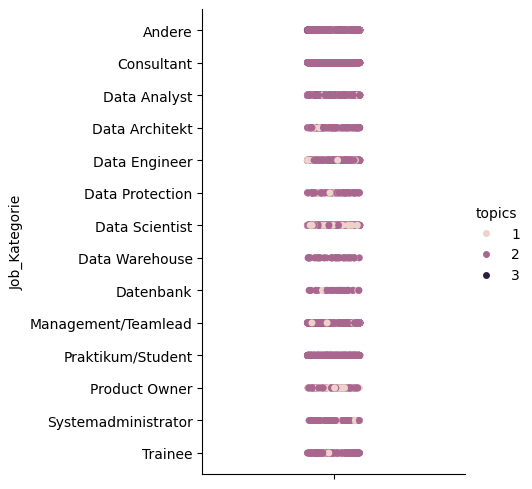

In [17]:
sns.catplot(data=df_tfidf, hue="topics", y="Job_Kategorie")